**Packages**

In [1]:
#!python -m pip install seaborn
#!pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sn

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import sklearn

import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer, normalize


import os

import scipy

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN 
from collections import Counter

2023-04-08 04:58:17.234380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 04:58:17.369876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-08 04:58:17.369902: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-08 04:58:18.231130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Helper Functions**

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [4]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [5]:
def plot_f1_macro(history):
    plt.plot(history.history['f1_macro'], label='train_f1')
    plt.plot(history.history['val_f1_macro'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_macro']),
                max(history.history['val_f1_macro'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Macro F1 Score')
    plt.legend()
    plt.grid(True)

In [6]:
def plot_f1_weighted(history):
    plt.plot(history.history['f1_weighted'], label='train_f1')
    plt.plot(history.history['val_f1_weighted'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_weighted']),
                max(history.history['val_f1_weighted'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Weighted F1 Score')
    plt.title('Weighted F1 Score')
    plt.legend()
    plt.grid(True)

In [7]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x1 = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x2 = make_layer(x1, 128, blocks_per_layer[1], stride=2, name='layer2')
    x3 = make_layer(x2, 256, blocks_per_layer[2], stride=2, name='layer3')
    x4 = make_layer(x3, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x4)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [8]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
#x_train = tiles_train.drop(['bins_numeric'], axis = 1)
#y_train = tiles_train['bins_numeric']
#x_train.head(5)

In [9]:
tiles_train.columns

Index(['Tile_ID', 'Stop_Signs', 'Paving_historical', 'Bus_stop',
       'Collisions_Historical', 'RTTYP_I', 'RTTYP_M', 'RTTYP_O', 'RTTYP_S',
       'RTTYP_U', 'bins_numeric', '94101', '94102', '94104', '94105', '94107',
       '94108', '94109', '94110', '94111', '94112', '94114', '94115', '94116',
       '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129',
       '94130', '94131', '94132', '94133', '94134', '94141', '94143', '94158',
       '94188'],
      dtype='object')

In [10]:
tiles_train['bins_numeric'].value_counts()

0     6644
2     1201
3      283
1      134
6       61
4       26
7       14
5        5
8        4
10       3
9        1
Name: bins_numeric, dtype: int64

In [11]:
counter = Counter(tiles_train['bins_numeric'])
print(counter)
ros = RandomOverSampler(random_state=0,sampling_strategy={0:6644, 2:1201, 3:283, 1:230, 6:150, 4:100, 7:100, 5:100,10:100,8:100,9:100}) # 0.77
# ros = RandomOverSampler(random_state=0,sampling_strategy={0:5297, 2:2400, 3:419, 1:108, 6:150, 4:100, 7:44, 5:40,10:30,8:30,9:10})
x_train, y_train = ros.fit_resample(tiles_train.drop(['bins_numeric'], axis = 1), tiles_train['bins_numeric'])
counter_sampled = Counter(y_train)
print(counter_sampled)

Counter({0: 6644, 2: 1201, 3: 283, 1: 134, 6: 61, 4: 26, 7: 14, 5: 5, 8: 4, 10: 3, 9: 1})
Counter({0: 6644, 2: 1201, 3: 283, 1: 230, 6: 150, 5: 100, 4: 100, 7: 100, 10: 100, 8: 100, 9: 100})


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
x_train.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
5775,6953,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8940,9358,0.0,0.0,2.0,20.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5833,7882,4.0,0.0,0.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7515,2910,0.0,0.0,2.0,4.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6883,4360,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
y_train.value_counts()

0     5289
2     1006
3      229
1      177
6      120
9       82
10      79
7       79
4       76
5       76
8       73
Name: bins_numeric, dtype: int64

In [14]:
y_val.value_counts()

0     1355
2      195
3       54
1       53
6       30
8       27
4       24
5       24
10      21
7       21
9       18
Name: bins_numeric, dtype: int64

In [15]:
x_val.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
4779,8173,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7444,1790,2.0,0.0,1.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1882,7489,0.0,0.0,1.0,3.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7707,2109,0.0,0.0,1.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1198,7943,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
x_test = tiles_test.drop(['Tile_ID','bins_numeric'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,6.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [17]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [18]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(7286, 148, 188, 4)

In [19]:
x_train = x_train.drop(['Tile_ID'], axis = 1)

In [20]:
# VAL SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part15(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_val['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
#     images_mini = normalize(images_mini.reshape(6700,-1))
    
    return images_mini

In [21]:
images_mini_v = preprocess_data_part15(IMAGE_PATH)
np.shape(images_mini_v)

(1822, 148, 188, 4)

In [22]:
x_val = x_val.drop(['Tile_ID'], axis = 1)

In [23]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [24]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [25]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(7286, 1, 1, 39)

In [26]:
# VAL SET 

street_v = np.asarray(x_val).astype('float32')
street_mini_v = []
for row in range(len(street_v)):
    street_mini_v.append([[street_v[row]]])
street_mini_v = np.stack(street_mini_v)
np.shape(street_mini_v)

(1822, 1, 1, 39)

In [27]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 39)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.9.0: Simplified CNN**

In [28]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5289
1      177
2     1006
3      229
4       76
5       76
6      120
7       79
8       73
9       82
10      79


In [29]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.12523419103112807,
 1: 3.742167437082691,
 2: 0.6584131574191217,
 3: 2.89241762604208,
 4: 8.71531100478469,
 5: 8.71531100478469,
 6: 5.5196969696969695,
 7: 8.384349827387801,
 8: 9.073474470734745,
 9: 8.077605321507761,
 10: 8.384349827387801}

In [30]:
street_mini_2 = [] 
for k in range(len(street)):
    for i in range(50): 
        for j in range(50):
            street_mini_2.append(street[k])
street_mini_2 = np.reshape(street_mini_2, (len(street),50,50,39))
np.shape(street_mini_2)

(7286, 50, 50, 39)

In [31]:
street_mini_2_v = [] 
for k in range(len(street_v)):
    for i in range(50): 
        for j in range(50):
            street_mini_2_v.append(street_v[k])
street_mini_2_v = np.reshape(street_mini_2_v, (len(street_v),50,50,39))
np.shape(street_mini_2_v)

(1822, 50, 50, 39)

In [32]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(50,50,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(6, (3,3), activation="relu")(input1) # layers = street data dimension, changed dimensions to be according to paper
    pooling = tf.keras.layers.MaxPooling2D((99, 139), strides=1)(cnn) #downsizing, per paper
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    cnn2 = tf.keras.layers.Conv2D(2, (3,3), activation="relu")(input2)
    street = tf.keras.models.Model(inputs=input2, outputs=cnn2)
    
    combined = tf.keras.layers.Concatenate(axis = 3)([images.output, street.output])
    #combined = tf.keras.layers.Add()([images.output, street.output])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    #resnet = resnet18(combined)
    
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(combined) # layers = street data dimension
    
    x = layers.GlobalAveragePooling2D(name='avgpool')(cnn)
    
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(x) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1_m = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1_macro',
    )

f1_w = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'weighted',
    threshold = None,
    name = 'f1_weighted',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning rate defined by scheduler
    loss='categorical_crossentropy',
    metrics = ['accuracy', keras.metrics.Precision(), f1_m, f1_w])

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

# define the checkpoint
filepath = "model.9"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_weighted', verbose=1, save_best_only=True, mode='max')
callbacks_check = checkpoint

def scheduler(epoch, lr):
    if epoch < 8:
        return 0.0001
    elif epoch < 13:
        return 0.00001
    else:
        return 0.000001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = cnn_model.fit(
    [images_mini, street_mini_2],
    y_t,
    epochs=15,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_2_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights,
    callbacks=[callback, callbacks_check],
    )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 146, 186, 6)  222         ['Input_Images[0][0]']           
                                                                                                  
 Input_Street (InputLayer)      [(None, 50, 50, 39)  0           []                               
                                ]                                                                 
                                                                                            

2023-04-08 05:00:11.961667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-08 05:00:11.961703: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-08 05:00:11.961733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-91): /proc/driver/nvidia/version does not exist
2023-04-08 05:00:11.962830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 05:00:12.196124: W tensorflow/tsl/framework/cpu_allocator

Epoch 1/15
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
228/228 [==============================] - ETA: 0s - loss: 2.4011 - accuracy: 0.1683 - precision: 0.0000e+00 - f1_macro: 0.0333 - f1_weighted: 0.2385 
Epoch 1: val_f1_weighted improved from -inf to 0.35285, saving model to model.9


INFO:tensorflow:Assets written to: model.9/assets


INFO:tensorflow:Assets written to: model.9/assets


228/228 [==============================] - 4390s 19s/step - loss: 2.4011 - accuracy: 0.1683 - precision: 0.0000e+00 - f1_macro: 0.0333 - f1_weighted: 0.2385 - val_loss: 2.3406 - val_accuracy: 0.2640 - val_precision: 0.0000e+00 - val_f1_macro: 0.0481 - val_f1_weighted: 0.3529 - lr: 1.0000e-04
Epoch 2/15
228/228 [==============================] - ETA: 0s - loss: 2.3814 - accuracy: 0.5435 - precision: 0.0000e+00 - f1_macro: 0.0877 - f1_weighted: 0.5717 
Epoch 2: val_f1_weighted improved from 0.35285 to 0.66610, saving model to model.9


INFO:tensorflow:Assets written to: model.9/assets


INFO:tensorflow:Assets written to: model.9/assets


228/228 [==============================] - 4370s 19s/step - loss: 2.3814 - accuracy: 0.5435 - precision: 0.0000e+00 - f1_macro: 0.0877 - f1_weighted: 0.5717 - val_loss: 2.0851 - val_accuracy: 0.6948 - val_precision: 0.0000e+00 - val_f1_macro: 0.1002 - val_f1_weighted: 0.6661 - lr: 1.0000e-04
Epoch 3/15
228/228 [==============================] - ETA: 0s - loss: 2.3006 - accuracy: 0.7240 - precision: 0.5000 - f1_macro: 0.1177 - f1_weighted: 0.6817 
Epoch 3: val_f1_weighted improved from 0.66610 to 0.70979, saving model to model.9


INFO:tensorflow:Assets written to: model.9/assets


INFO:tensorflow:Assets written to: model.9/assets


228/228 [==============================] - 4369s 19s/step - loss: 2.3006 - accuracy: 0.7240 - precision: 0.5000 - f1_macro: 0.1177 - f1_weighted: 0.6817 - val_loss: 1.4664 - val_accuracy: 0.7420 - val_precision: 0.8667 - val_f1_macro: 0.1181 - val_f1_weighted: 0.7098 - lr: 1.0000e-04
Epoch 4/15
228/228 [==============================] - ETA: 0s - loss: 2.1972 - accuracy: 0.7173 - precision: 0.8652 - f1_macro: 0.1247 - f1_weighted: 0.6920 
Epoch 4: val_f1_weighted did not improve from 0.70979
228/228 [==============================] - 4367s 19s/step - loss: 2.1972 - accuracy: 0.7173 - precision: 0.8652 - f1_macro: 0.1247 - f1_weighted: 0.6920 - val_loss: 1.1664 - val_accuracy: 0.7157 - val_precision: 0.9076 - val_f1_macro: 0.1253 - val_f1_weighted: 0.7046 - lr: 1.0000e-04
Epoch 5/15
228/228 [==============================] - ETA: 0s - loss: 2.1288 - accuracy: 0.6835 - precision: 0.8969 - f1_macro: 0.1343 - f1_weighted: 0.6791 
Epoch 5: val_f1_weighted did not improve from 0.70979
228/22

In [40]:
# saving last epoch model just in case 
cnn_model.save('model.9a.last.epoch')

INFO:tensorflow:Assets written to: model.9a.last.epoch/assets


INFO:tensorflow:Assets written to: model.9a.last.epoch/assets


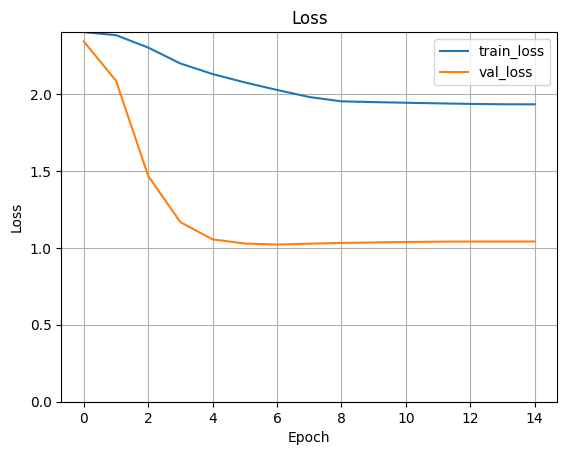

In [41]:
plot_loss(history)

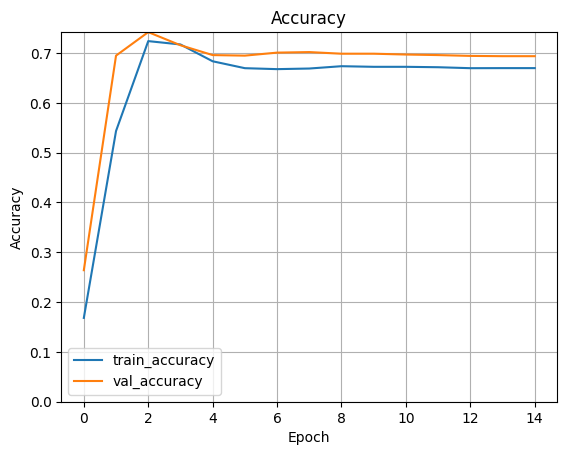

In [42]:
plot_accuracy(history)

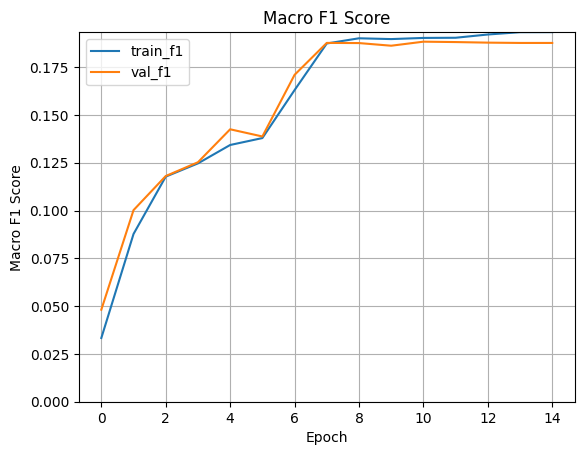

In [43]:
plot_f1_macro(history)

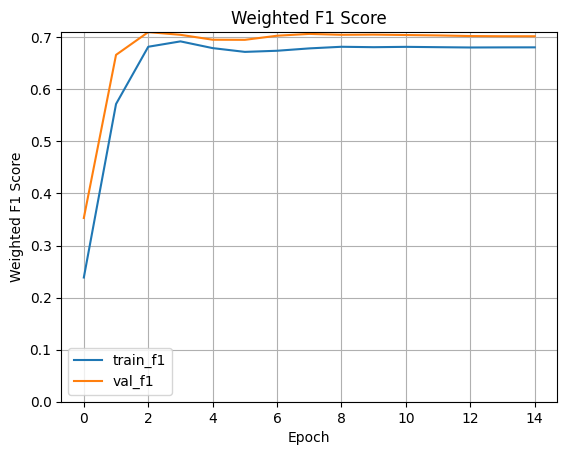

In [44]:
plot_f1_weighted(history)

**Analysis of Best Checkpoint Model**

In [46]:
# load the model
filepath = "model.9a"
best_model = load_model(filepath)

In [47]:
y_pred = best_model.predict([images_mini_v, street_mini_2_v])
y_pred

57/57 [==============================] - 65s 1s/step


array([[0.08955936, 0.10861241, 0.08947036, ..., 0.08590282, 0.08131593,
        0.09354587],
       [0.0918624 , 0.11770456, 0.0899149 , ..., 0.08024959, 0.07296339,
        0.08918291],
       [0.08677574, 0.14411423, 0.10066072, ..., 0.05564682, 0.06841826,
        0.11501734],
       ...,
       [0.0933817 , 0.11457869, 0.09234195, ..., 0.08054277, 0.07080285,
        0.08796627],
       [0.08978748, 0.11176183, 0.09198775, ..., 0.08502644, 0.07573849,
        0.09530602],
       [0.08972348, 0.1170605 , 0.09127209, ..., 0.08109432, 0.07492549,
        0.09097836]], dtype=float32)

In [48]:
pred_values = []
for i in y_pred: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values.append(index[0])
pred_values[0:5]

[1, 1, 1, 1, 1]

In [49]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 6, 0, 0]

<Axes: title={'center': 'Confusion Matrix'}>

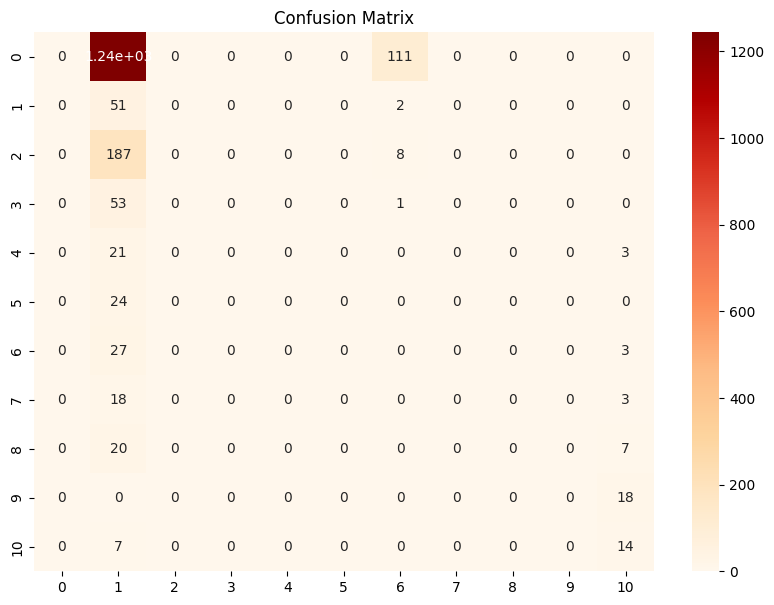

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values)
ind = max(max(np.unique(y_true)), max(np.unique(pred_values))) + 1
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
sn.heatmap(df_cm, annot=True, fmt='.3g',cmap="OrRd")